Jonathon Nguyen

ID: 801093003

Homework 2

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
from torchvision import datasets
import time

In [2]:
# Find the normalized of the input tensor.
def normalized_data(tensor):
    mean = torch.mean(tensor)
    std = torch.std(tensor)
    new_tensor = (tensor - mean) / std
    
    return new_tensor

def training_loop(epochs, optimizer, model, loss_fn, training_vars, validation_vars, 
                  training_prices, validation_prices):
    training_losses = []
    val_losses = []
    for epoch in range(1, epochs + 1):
        # Validation model and loss
        loss_val_values = 0
        with torch.no_grad():
            prices_p_val = torch.squeeze(model(validation_vars))
            loss_val = loss_fn(prices_p_val, validation_prices)
            
        val_losses.append(float(loss_val)) 
        
        # Training model and loss
        prices_p_train = torch.squeeze(model(training_vars))
        loss_train = loss_fn(prices_p_train, training_prices)

        # Set the new params.
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        
        training_losses.append(float(loss_train)) 
        
        # Print out the losses every 10 epoch
        if epoch % 10 == 0 or epoch == 1:
            print(f'Epoch {epoch}: Training Loss: {float(loss_train)}, Validation Loss: {float(loss_val)}')
    
    return training_losses, val_losses

In [3]:
NUM_EPOCHS = 300

# Read the data from the provided CSV files
housing = pd.DataFrame(pd.read_csv("Housing.csv"))

# Split the data into the input vars and the prices.
names_vars = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking']
prices = housing['price']

# Find the length of the column.
num_samples = len(prices)
num_val = int(0.2 * num_samples)

# Generate the random indices with 80% training and 20% Validation
random_indices = torch.randperm(num_samples)
training_indices = random_indices[:-num_val]
validation_indices = random_indices[-num_val:]

input_vars = torch.tensor(housing[names_vars].values).float()
training_tensor = normalized_data(input_vars[training_indices])
validation_tensor = normalized_data(input_vars[validation_indices])

# Convert the prices to a tensor.
prices = normalized_data(torch.tensor(prices.values).float())
price_training = prices[training_indices]
price_validation = prices[validation_indices]

In [4]:
# Model with one hidden layer of 8
model = nn.Sequential(
        nn.Linear(5, 8),
        nn.Tanh(),
        nn.Linear(8, 1))

optimizer = optim.SGD(model.parameters(), lr=.01)
loss_function = nn.MSELoss()

In [5]:
train_loss, val_loss = training_loop(NUM_EPOCHS, optimizer, model, loss_function, training_tensor, 
                                     validation_tensor, price_training, price_validation)

Epoch 1: Training Loss: 1.2460602521896362, Validation Loss: 1.3977521657943726
Epoch 10: Training Loss: 1.0101455450057983, Validation Loss: 1.151967167854309
Epoch 20: Training Loss: 0.9181671142578125, Validation Loss: 1.054456353187561
Epoch 30: Training Loss: 0.8796026706695557, Validation Loss: 1.0130778551101685
Epoch 40: Training Loss: 0.8576151728630066, Validation Loss: 0.989709198474884
Epoch 50: Training Loss: 0.8409616947174072, Validation Loss: 0.9724629521369934
Epoch 60: Training Loss: 0.8261151313781738, Validation Loss: 0.9574528932571411
Epoch 70: Training Loss: 0.812021791934967, Validation Loss: 0.9434162974357605
Epoch 80: Training Loss: 0.798433780670166, Validation Loss: 0.9299797415733337
Epoch 90: Training Loss: 0.7853594422340393, Validation Loss: 0.917076051235199
Epoch 100: Training Loss: 0.7728792428970337, Validation Loss: 0.904740571975708
Epoch 110: Training Loss: 0.7610804438591003, Validation Loss: 0.8930349946022034
Epoch 120: Training Loss: 0.750035

Text(0.5, 1.0, 'Losses')

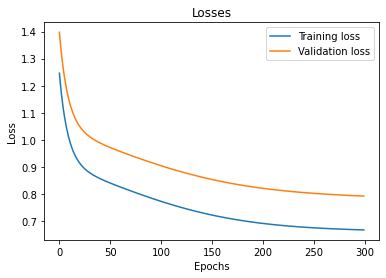

In [6]:
# Plotting the Losses

fig = plt.figure()
# Name the x and y axis
plt.xlabel("Epochs")
plt.ylabel("Loss")

# Plot the model and the actual values.
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.legend()
plt.title("Losses")

In [7]:
# Model with three hidden layer of 8, 32, 10
model_new = nn.Sequential(
        nn.Linear(5, 8),
        nn.Tanh(),
        nn.Linear(8, 32),
        nn.Tanh(),
        nn.Linear(32, 10),
        nn.Tanh(),
        nn.Linear(10, 1))

optimizer = optim.SGD(model_new.parameters(), lr=.01)

train_loss, val_loss = training_loop(NUM_EPOCHS, optimizer, model_new, nn.MSELoss(), training_tensor, 
                                     validation_tensor, price_training, price_validation)

Epoch 1: Training Loss: 1.008755087852478, Validation Loss: 1.1300957202911377
Epoch 10: Training Loss: 0.9911390542984009, Validation Loss: 1.1144399642944336
Epoch 20: Training Loss: 0.9779357314109802, Validation Loss: 1.1026506423950195
Epoch 30: Training Loss: 0.9675033092498779, Validation Loss: 1.0931150913238525
Epoch 40: Training Loss: 0.9581463932991028, Validation Loss: 1.0843251943588257
Epoch 50: Training Loss: 0.9491453766822815, Validation Loss: 1.0756783485412598
Epoch 60: Training Loss: 0.9401654005050659, Validation Loss: 1.0669103860855103
Epoch 70: Training Loss: 0.9310250878334045, Validation Loss: 1.0578820705413818
Epoch 80: Training Loss: 0.9216070175170898, Validation Loss: 1.0485001802444458
Epoch 90: Training Loss: 0.9118227958679199, Validation Loss: 1.0386887788772583
Epoch 100: Training Loss: 0.901601254940033, Validation Loss: 1.028381586074829
Epoch 110: Training Loss: 0.8908839225769043, Validation Loss: 1.0175195932388306
Epoch 120: Training Loss: 0.87

Text(0.5, 1.0, 'Losses')

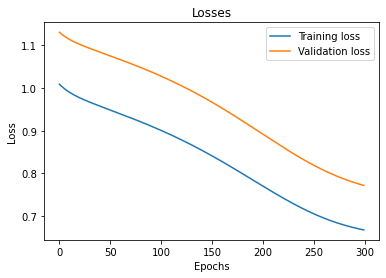

In [8]:
# Plotting the Losses

fig = plt.figure()
# Name the x and y axis
plt.xlabel("Epochs")
plt.ylabel("Loss")

# Plot the model and the actual values.
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.legend()
plt.title("Losses")

Problem 2

In [9]:
from torchvision import transforms

transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4915, 0.4823, 0.4468),
                         (0.2470, 0.2435, 0.2616))
])

def training_loop(epochs, optimizer, model, loss_fn, train_loader, val_loader):
    training_losses = []
    val_losses = []
    accuracies = []
    for epoch in range(1, epochs + 1):
        # Temp vars for use in finding the accuracy.
        correct_labels = 0
        count = 0
        loss_val_value = 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                # Pass imgs through the model and find the loss.
                output = model(imgs.view(imgs.shape[0], -1))
                loss_val = loss_fn(output, labels)
                loss_val_value += float(loss_val)
                
                # Find the accurcey of the model.
                _, predicted = torch.max(output, dim=1)
                count += labels.shape[0]
                correct_labels += int((predicted == labels).sum())
            
            # Store the loss and accuracy.
            loss_val_value /= count
            val_losses.append(loss_val_value)
            accuracies.append(correct_labels/count)
        
        loss_train_value = 0
        for imgs, labels in train_loader:
            # Pass imgs through the model and find the loss.
            output = model(imgs.view(imgs.shape[0], -1))
            loss_train = loss_fn(output, labels)
            loss_train_value += float(loss_train)
            
            # Adject the params
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()
        
        # Store the loss
        loss_train_value /= count
        training_losses.append(loss_train_value)
        
        # Print out the loss every 10 epoch
        if epoch % 10 == 0 or epoch == 1:
            print(f"Epoch: {epoch}, Training Loss: {loss_train}, Validation Loss: {loss_val}, Accuracy: {(correct_labels/count)*100}%")
        
    return training_losses, val_losses, accuracies

In [10]:
# Download the cifar10 dataset.
data = '.\cifar10'
cirfar10_train = datasets.CIFAR10(data, train=True, download=True, transform=transforms)
cirfar10_val = datasets.CIFAR10(data, train=False, download=True, transform=transforms)

Files already downloaded and verified
Files already downloaded and verified


In [11]:
NUM_EPOCHS = 300
LEARNING_RATE = 1e-2
BATCH_SIZE = 1024

# Neural Net with one hidden layer of 512
model = nn.Sequential(
        nn.Linear(3072, 512),
        nn.Tanh(),
        nn.Linear(512, 10),
        nn.LogSoftmax(dim=1))

loss = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

# Load the data into a dataloader.
train_loader = torch.utils.data.DataLoader(cirfar10_train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(cirfar10_val, batch_size=BATCH_SIZE, shuffle=False)

In [12]:
# Using time to time the training.
start_time = time.time()
training_losses, val_losses, accuracies = training_loop(NUM_EPOCHS, optimizer, model, loss, train_loader, val_loader)
end_time = time.time()

# Report the final stats about the training.
print(" ")
print(f"Final Loss: {training_losses[-1]}, Final Accuracy: {accuracies[-1] * 100}%")
print(f"Training Time: {(end_time - start_time):.2f} seconds")

Epoch: 1, Training Loss: 1.9678707122802734, Validation Loss: 2.2674553394317627, Accuracy: 13.19%
Epoch: 10, Training Loss: 1.680593490600586, Validation Loss: 1.7601591348648071, Accuracy: 39.629999999999995%
Epoch: 20, Training Loss: 1.683751106262207, Validation Loss: 1.7104140520095825, Accuracy: 41.81%
Epoch: 30, Training Loss: 1.6511505842208862, Validation Loss: 1.6814672946929932, Accuracy: 42.76%
Epoch: 40, Training Loss: 1.5423791408538818, Validation Loss: 1.661741018295288, Accuracy: 43.730000000000004%
Epoch: 50, Training Loss: 1.5605401992797852, Validation Loss: 1.6429061889648438, Accuracy: 44.24%
Epoch: 60, Training Loss: 1.4842920303344727, Validation Loss: 1.6270273923873901, Accuracy: 45.07%
Epoch: 70, Training Loss: 1.4811780452728271, Validation Loss: 1.614139199256897, Accuracy: 45.440000000000005%
Epoch: 80, Training Loss: 1.4788289070129395, Validation Loss: 1.5981080532073975, Accuracy: 46.02%
Epoch: 90, Training Loss: 1.4786642789840698, Validation Loss: 1.5

Text(0.5, 1.0, 'Accuracy')

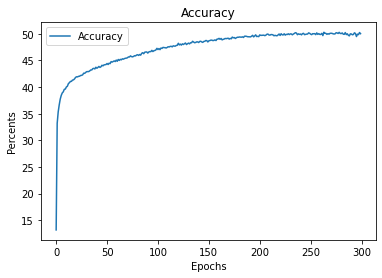

In [14]:
# Plotting the accuracy of the model.

fig = plt.figure()
# Name the x and y axis
plt.xlabel("Epochs")
plt.ylabel("Percents")

for i, x in enumerate(accuracies):
    accuracies[i] = x * 100
    

plt.plot(accuracies, label='Accuracy')
plt.legend()
plt.title("Accuracy")

In [15]:
# Two new layers in the model.
model_new = nn.Sequential(
            nn.Linear(3072, 512),
            nn.Tanh(),
            nn.Linear(512, 1024),
            nn.Tanh(),
            nn.Linear(1024, 256),
            nn.Tanh(),
            nn.Linear(256, 10),
            nn.LogSoftmax(dim=1))

loss = nn.NLLLoss()
optimizer = optim.SGD(model_new.parameters(), lr=LEARNING_RATE)

# Using new model in the loop. Timing it with the same method.
start_time = time.time()
training_losses, val_losses, accuracies = training_loop(NUM_EPOCHS, optimizer, model_new, loss, train_loader, val_loader)
end_time = time.time()

# Report the final stats about the training.
print(" ")
print(f"Final Loss: {training_losses[-1]}, Final Accuracy: {accuracies[-1] * 100}%")
print(f"Training Time: {(end_time - start_time):.2f} seconds")

Epoch: 1, Training Loss: 2.1452176570892334, Validation Loss: 2.3103466033935547, Accuracy: 10.32%
Epoch: 10, Training Loss: 1.8333007097244263, Validation Loss: 1.8492969274520874, Accuracy: 36.25%
Epoch: 20, Training Loss: 1.7433573007583618, Validation Loss: 1.7603672742843628, Accuracy: 39.42%
Epoch: 30, Training Loss: 1.7012865543365479, Validation Loss: 1.7154326438903809, Accuracy: 41.14%
Epoch: 40, Training Loss: 1.6453821659088135, Validation Loss: 1.6865911483764648, Accuracy: 42.49%
Epoch: 50, Training Loss: 1.6486808061599731, Validation Loss: 1.66253662109375, Accuracy: 43.169999999999995%
Epoch: 60, Training Loss: 1.5862213373184204, Validation Loss: 1.6396384239196777, Accuracy: 43.89%
Epoch: 70, Training Loss: 1.540399193763733, Validation Loss: 1.6203588247299194, Accuracy: 45.04%
Epoch: 80, Training Loss: 1.5035895109176636, Validation Loss: 1.5962070226669312, Accuracy: 45.98%
Epoch: 90, Training Loss: 1.5043388605117798, Validation Loss: 1.5754191875457764, Accuracy

Text(0.5, 1.0, 'Accuracy')

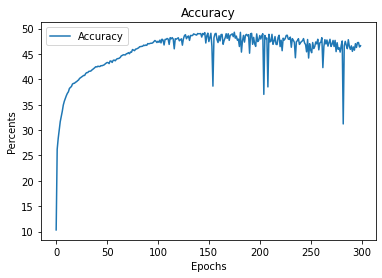

In [17]:
# Plotting the accuracy of the model.

fig = plt.figure()
# Name the x and y axis
plt.xlabel("Epochs")
plt.ylabel("Percents")

for i, x in enumerate(accuracies):
    accuracies[i] = x * 100

plt.plot(accuracies, label='Accuracy')
plt.legend()
plt.title("Accuracy")

In [35]:
# Model with one hidden layer of 8
model_p1p1 = nn.Sequential(
        nn.Linear(5, 8),
        nn.Tanh(),
        nn.Linear(8, 1))

# Model with three hidden layer of 8, 32, 10
model__p1p2 = nn.Sequential(
                nn.Linear(5, 8),
                nn.Tanh(),
                nn.Linear(8, 32),
                nn.Tanh(),
                nn.Linear(32, 10),
                nn.Tanh(),
                nn.Linear(10, 1))

from ptflops import get_model_complexity_info
import warnings
warnings.filterwarnings("ignore")

macs, params = get_model_complexity_info(model_p1p1, (436, 5), as_strings=True,
 print_per_layer_stat=False, verbose=False)
# print out the computational cost and the Model size.
print("Problem 1 Part 1")
print("Model size: " + params)

print("")

macs, params = get_model_complexity_info(model__p1p2, (436, 5), as_strings=True,
 print_per_layer_stat=False, verbose=False)
# print out the computational cost and the Model size.
print("Problem 1 Part 2")
print("Model size: " + params)

print("")

macs, params = get_model_complexity_info(model, (1, 3072), as_strings=True,
 print_per_layer_stat=False, verbose=False)
# print out the computational cost and the Model size.
print("Problem 2 Part 1")
print("Model size: " + params)

print("")

macs, params = get_model_complexity_info(model_new, (1, 3072), as_strings=True,
 print_per_layer_stat=False, verbose=False)
# print out the computational cost and the Model size.
print("Problem 2 Part 2")
print("Model size: " + params)


Problem 1 Part 1
Model size: 57

Problem 1 Part 2
Model size: 677

Problem 2 Part 1
Model size: 1.58 M

Problem 2 Part 2
Model size: 2.36 M
